In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style='whitegrid')

DATA_PATH = "data/"

json_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.json')]
print("Found JSON files:", json_files)


Found JSON files: ['compoundV2_transactions_ethereum_chunk_0.json', 'compoundV2_transactions_ethereum_chunk_1.json', 'compoundV2_transactions_ethereum_chunk_2.json', 'compoundV2_transactions_ethereum_chunk_3.json']


In [ ]:
#  Load and Flatten JSON Transactions

def extract_actions(df, action_name):
    rows = []
    for action_list in df[action_name].dropna():
        rows.extend(action_list)
    flat_df = pd.json_normalize(rows)
    flat_df['action_type'] = action_name[:-1]  
    return flat_df

all_raw = []
for file in json_files:
    file_path = os.path.join(DATA_PATH, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
        df = pd.json_normalize(data)
        all_raw.append(df)

raw_df = pd.concat(all_raw, ignore_index=True)

actions = ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']
action_dfs = [extract_actions(raw_df, act) for act in actions]

flat_df = pd.concat(action_dfs, ignore_index=True)
print("✅ Flattened shape:", flat_df.shape)
flat_df.head()


✅ Flattened shape: (180737, 11)


,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,action_type,liquidatee.id,liquidator.id
0,10000000000000000,1.78010000000000014408,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,1557193282,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposit,NaN,NaN
1,80000000000000000,14.24080000000000115264,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,1557193511,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposit,NaN,NaN
2,4582920657824222640301,1562.320140205329756474017145956277,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,1557195125,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,deposit,NaN,NaN
3,4013962940167102266494,4013.962940167102266494,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,1557195125,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,deposit,NaN,NaN
4,9990000000000000000,1775.4727500000001641357,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,1557196912,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposit,NaN,NaN


In [ ]:
#  Clean and Normalize Flat DataFrame

flat_df = flat_df.rename(columns={
    'account.id': 'wallet_address',
    'timestamp': 'timestamp',
    'amountUSD': 'amount_usd',
    'asset.symbol': 'token_symbol'
})

flat_df['timestamp'] = pd.to_datetime(flat_df['timestamp'], unit='s', errors='coerce')
flat_df['amount_usd'] = pd.to_numeric(flat_df['amount_usd'], errors='coerce')

flat_df = flat_df.dropna(subset=['wallet_address', 'amount_usd'])

flat_df = flat_df[['wallet_address', 'timestamp', 'token_symbol', 'amount_usd', 'action_type']]
print("✅ Cleaned shape:", flat_df.shape)
flat_df.head()


C:\Users\mithu\AppData\Local\Temp\ipykernel_5376\2020663021.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  flat_df['timestamp'] = pd.to_datetime(flat_df['timestamp'], unit='s', errors='coerce')


✅ Cleaned shape: (160000, 5)


,wallet_address,timestamp,token_symbol,amount_usd,action_type
0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,2019-05-07 01:42:24,ETH,1.78010,deposit
1,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,2019-05-07 01:44:32,ETH,14.24080,deposit
2,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,2019-05-07 02:12:16,BAT,1562.32014,deposit
3,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,2019-05-07 02:12:16,DAI,4013.96294,deposit
4,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,2019-05-07 02:42:08,ETH,1775.47275,deposit


In [ ]:
# Wallet-Level Aggregation

#  Count action type per wallet
action_counts = flat_df.pivot_table(
    index='wallet_address',
    columns='action_type',
    values='amount_usd',
    aggfunc='count',
    fill_value=0
).reset_index()

#  Aggregate financial & activity stats
amount_stats = flat_df.groupby('wallet_address').agg(
    total_txns=('amount_usd', 'count'),
    total_usd=('amount_usd', 'sum'),
    avg_usd=('amount_usd', 'mean'),
    first_activity=('timestamp', 'min'),
    last_activity=('timestamp', 'max'),
    active_days=('timestamp', lambda x: (x.max() - x.min()).days + 1)
).reset_index()

wallet_features = pd.merge(action_counts, amount_stats, on='wallet_address', how='inner')

for col in ['deposit', 'withdraw', 'borrow', 'repay', 'liquidate']:
    if col not in wallet_features.columns:
        wallet_features[col] = 0

print("✅ Wallet feature table shape:", wallet_features.shape)
wallet_features.head()


✅ Wallet feature table shape: (18664, 12)


,wallet_address,borrow,deposit,repay,withdraw,total_txns,total_usd,avg_usd,first_activity,last_activity,active_days,liquidate
0,0x00000000af5a61acaf76190794e3fdf1289288a1,0,0,49,73,122,1.448566e+05,1187.349498,2019-08-14 17:21:04,2019-12-25 06:34:40,133,0
1,0x00000000b1786c9698c160d78232c78d6f6474fe,0,0,30,0,30,2.947552e+04,982.517467,2020-02-12 20:48:00,2020-06-02 15:00:16,111,0
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,9,0,8,0,17,4.385511e+05,25797.124308,2020-06-15 20:43:44,2020-06-22 16:46:56,7,0
3,0x000000aaee6a496aaf7b7452518781786313400f,157,79,138,167,541,8.959501e+06,16561.000634,2019-07-02 10:54:56,2020-03-19 20:01:04,262,0
4,0x00000a6bbb35ea3f6f8dbc94801738f490c30a8d,0,2,0,2,4,1.210531e+01,3.026328,2019-06-03 23:57:52,2019-07-09 08:00:00,36,0


In [ ]:
#  Derived Behavior Features

# Ratios
wallet_features['repay_borrow_ratio'] = wallet_features['repay'] / (wallet_features['borrow'] + 1)
wallet_features['deposit_withdraw_ratio'] = wallet_features['deposit'] / (wallet_features['withdraw'] + 1)
wallet_features['liquidation_rate'] = wallet_features['liquidate'] / (wallet_features['borrow'] + 1)
wallet_features['activity_score'] = wallet_features['active_days'] / wallet_features['active_days'].max()

# Borrow with no repay (binary flag)
wallet_features['borrow_no_repay'] = np.where(
    (wallet_features['borrow'] > 0) & (wallet_features['repay'] == 0), 1, 0
)

# Token diversity
token_counts = flat_df.groupby('wallet_address')['token_symbol'].nunique().reset_index()
token_counts.columns = ['wallet_address', 'unique_tokens']
wallet_features = wallet_features.merge(token_counts, on='wallet_address', how='left')
wallet_features['unique_tokens'] = wallet_features['unique_tokens'].fillna(0)

# Repay-to-borrow USD ratio
borrow_usd = flat_df[flat_df['action_type'] == 'borrow'].groupby('wallet_address')['amount_usd'].sum().reset_index(name='borrow_usd')
repay_usd = flat_df[flat_df['action_type'] == 'repay'].groupby('wallet_address')['amount_usd'].sum().reset_index(name='repay_usd')
usd_ratio = pd.merge(borrow_usd, repay_usd, on='wallet_address', how='outer').fillna(0)
usd_ratio['repay_usd_ratio'] = usd_ratio['repay_usd'] / (usd_ratio['borrow_usd'] + 1)
wallet_features = wallet_features.merge(usd_ratio[['wallet_address', 'repay_usd_ratio']], on='wallet_address', how='left')
wallet_features['repay_usd_ratio'] = wallet_features['repay_usd_ratio'].fillna(0)

print("✅ Behavior features added. New shape:", wallet_features.shape)
wallet_features[['repay_borrow_ratio', 'deposit_withdraw_ratio', 'liquidation_rate', 'activity_score', 'borrow_no_repay', 'unique_tokens', 'repay_usd_ratio']].describe()


✅ Behavior features added. New shape: (18664, 19)


,repay_borrow_ratio,deposit_withdraw_ratio,liquidation_rate,activity_score,borrow_no_repay,unique_tokens,repay_usd_ratio
count,18664.000000,18664.000000,18664.0,18664.000000,18664.000000,18664.000000,1.866400e+04
mean,0.643907,0.706037,0.0,0.090672,0.090441,1.525879,1.267020e+04
std,34.622237,1.084753,0.0,0.165933,0.286821,0.950455,5.987531e+05
min,0.000000,0.000000,0.0,0.002427,0.000000,1.000000,0.000000e+00
25%,0.000000,0.000000,0.0,0.002427,0.000000,1.000000,0.000000e+00
50%,0.000000,0.500000,0.0,0.009709,0.000000,1.000000,0.000000e+00
75%,0.333333,1.000000,0.0,0.106796,0.000000,2.000000,3.124935e-01
max,4696.000000,24.500000,0.0,1.000000,1.000000,8.000000,5.042129e+07


In [ ]:
# Rule-Based Scoring Function

def calculate_score(row):
    score = 0
    score += 30 * min(row['repay_borrow_ratio'], 1)
    score += 25 * np.tanh(row['deposit_withdraw_ratio'])
    score += 20 * row['activity_score']
    score -= 25 * row['liquidation_rate']
    score -= 10 * row['borrow_no_repay']
    score += 10 * np.tanh(row['unique_tokens'] / 5)
    score += 10 * np.tanh(row['repay_usd_ratio'])
    return max(0, min(100, score))

wallet_features['credit_score'] = wallet_features.apply(calculate_score, axis=1)

wallet_features[['wallet_address', 'credit_score']].sort_values(by='credit_score', ascending=False).head()


,wallet_address,credit_score
11165,0x99cd4625a58c27df7616fd4e5caba5803a875cfd,88.190254
5190,0x46a0b4fa58141aba23185e79f7047a7dfd0ff100,87.878149
1393,0x124e1fafcadc2c017a17b4bbbbfff3867b7dee35,87.779892
5803,0x4f5c0754c5f90e722d78964644bd29687b87c584,87.697552
3609,0x30caf91380d5911d417f5dada36f145897bc7f72,87.141222


In [ ]:
#  KMeans Clustering for Behavior Grouping

# Select features for clustering
cluster_features = wallet_features[[
    'repay_borrow_ratio', 
    'deposit_withdraw_ratio', 
    'liquidation_rate', 
    'activity_score', 
    'avg_usd'
]].fillna(0)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

#  KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
wallet_features['cluster'] = kmeans.fit_predict(X_scaled)

# Map cluster → trust score
cluster_map = {
    0: 90,
    1: 70,
    2: 40,
    3: 50  
}
wallet_features['cluster_score'] = wallet_features['cluster'].map(cluster_map)

score = silhouette_score(X_scaled, wallet_features['cluster'])
print(f"✅ Clustering complete | Silhouette Score: {score:.3f}")
wallet_features[['wallet_address', 'cluster', 'cluster_score']].head()


c:\Users\mithu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


✅ Clustering complete | Silhouette Score: 0.617


,wallet_address,cluster,cluster_score
0,0x00000000af5a61acaf76190794e3fdf1289288a1,2,40
1,0x00000000b1786c9698c160d78232c78d6f6474fe,0,90
2,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0,90
3,0x000000aaee6a496aaf7b7452518781786313400f,2,40
4,0x00000a6bbb35ea3f6f8dbc94801738f490c30a8d,0,90


In [ ]:
#   Hybrid Scoring 

# Final weighted score (60% rule-based, 40% cluster-based)
wallet_features['hybrid_score'] = (
    0.6 * wallet_features['credit_score'] +
    0.4 * wallet_features['cluster_score']
).clip(0, 100)

top_1000 = wallet_features[['wallet_address', 'hybrid_score']].sort_values(
    by='hybrid_score', ascending=False
).head(1000)

os.makedirs("outputs", exist_ok=True)
top_1000.to_csv("outputs/wallet_scores_hybrid.csv", index=False)

print("✅ Top 1000 hybrid scores saved to: outputs/wallet_scores_hybrid.csv")
top_1000.head()


✅ Top 1000 hybrid scores saved to: outputs/wallet_scores_hybrid.csv


,wallet_address,hybrid_score
1887,0x1954c8cd151de0d0946fcc1e8a97545f711e2380,78.695420
15814,0xd84e11bee5d555ccd905817cb8cbbd5b6e6c4f0d,78.554421
10006,0x89ff1c432d8adf7b4777117f91d58d4b64595ca7,77.986388
358,0x03e3702d91098350d057ded0a05095f703bba2e7,77.665308
9182,0x7ef5774cb1cb4a6829a85738d4c6956e2edc5be4,77.593310


c:\Users\mithu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mithu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


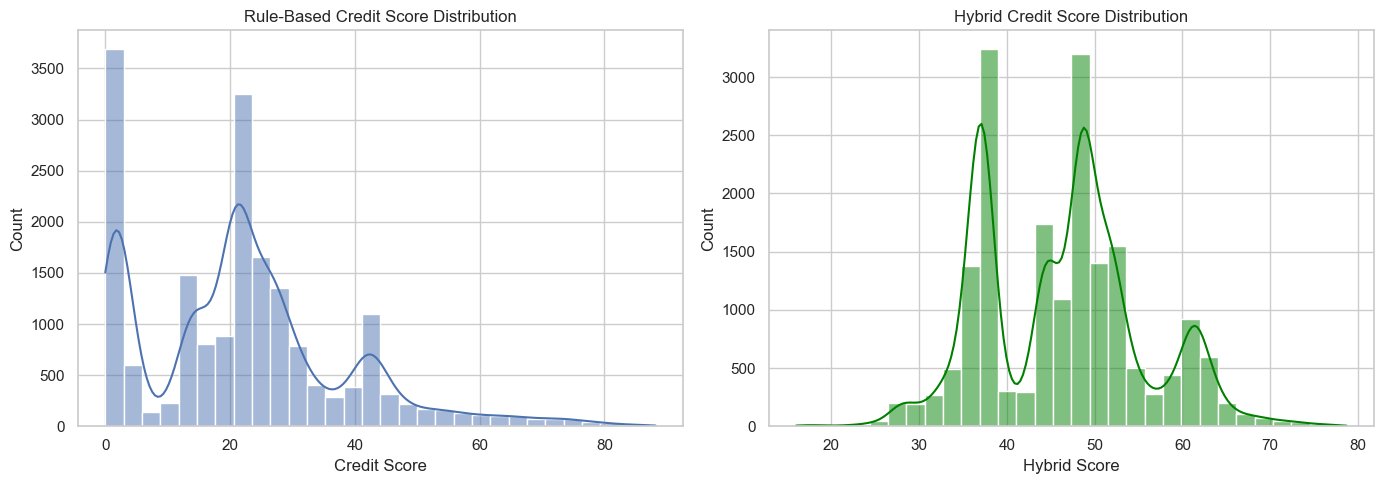

In [ ]:
#  Score Distribution Comparison

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(wallet_features['credit_score'], bins=30, kde=True)
plt.title("Rule-Based Credit Score Distribution")
plt.xlabel("Credit Score")

plt.subplot(1, 2, 2)
sns.histplot(wallet_features['hybrid_score'], bins=30, kde=True, color='green')
plt.title("Hybrid Credit Score Distribution")
plt.xlabel("Hybrid Score")

plt.tight_layout()
plt.show()


Rule-Based Credit Score
Heavily left-skewed, with a large concentration of scores near 0 and 20. Indicates that many wallets have poor repayment behavior, low activity, or are bots/passive users. Very few wallets cross 60+, showing that the rule-based logic is strict.

Hybrid Credit Score
Smoother, multi-modal distribution, with peaks around 38, 48, and 58. The hybrid model brings better separation of wallet types by incorporating unsupervised clustering. The distribution avoids harsh cutoffs, improving fairness and realism. 


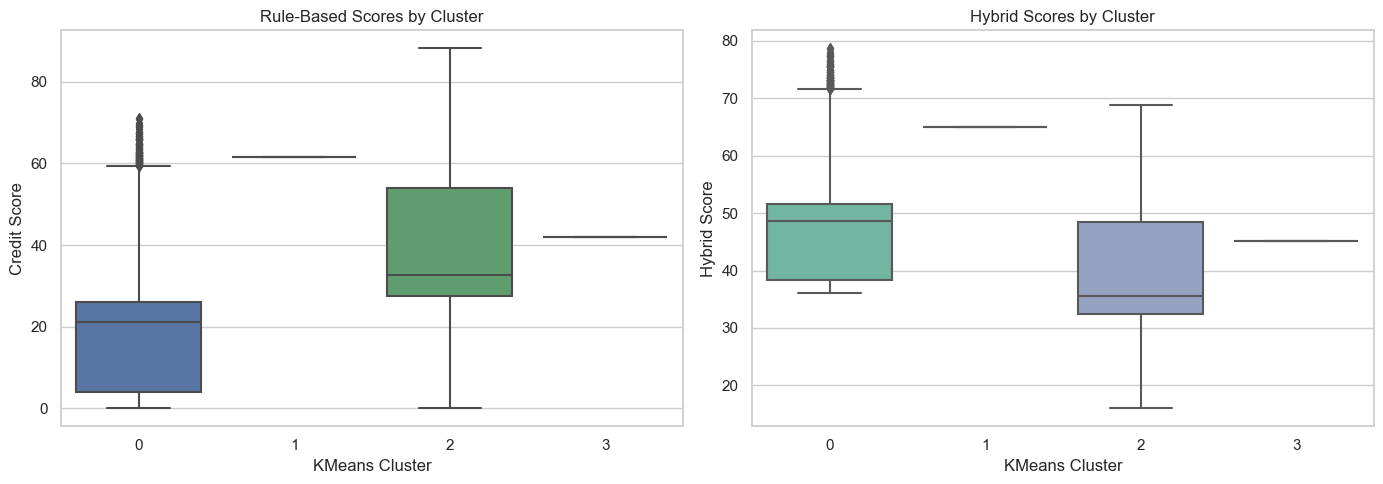

In [46]:
#  Rule-Based vs Hybrid Scores by Cluster

plt.figure(figsize=(14, 5))

# Rule-Based Score
plt.subplot(1, 2, 1)
sns.boxplot(data=wallet_features, x='cluster', y='credit_score')
plt.title("Rule-Based Scores by Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("Credit Score")

# Hybrid Score
plt.subplot(1, 2, 2)
sns.boxplot(data=wallet_features, x='cluster', y='hybrid_score', palette='Set2')
plt.title("Hybrid Scores by Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("Hybrid Score")

plt.tight_layout()
plt.show()


Boxplots by Cluster
Rule-Based Scores
Cluster 0: Broad range with mostly low scores (risky or inactive wallets).

Cluster 1: Flat band, indicates low variation — possibly some scoring bias.

Cluster 2: Widest spread, contains both risky and good users.

Cluster 3: Mid-level, likely edge cases or bots.

Hybrid Scores
Hybrid scoring smooths the spread across clusters.

Cluster 0 still holds most low performers, but separation is better.

Clusters 1 and 2 now show distinct central tendencies, meaning hybrid scoring helped reduce bias and cluster overlap.



In [ ]:
# High Scoring Wallet

top_wallet = wallet_features.sort_values(by='hybrid_score', ascending=False).iloc[0]
wallet_features[wallet_features['wallet_address'] == top_wallet['wallet_address']].T


,1887
wallet_address,0x1954c8cd151de0d0946fcc1e8a97545f711e2380
borrow,4
deposit,17
repay,5
withdraw,9
total_txns,35
total_usd,4513.485793
avg_usd,128.956737
first_activity,2019-07-18 05:52:00
last_activity,2019-08-14 05:15:44


In [ ]:
# 🔍 Wallet Behavior Analysis – Top 5 and Bottom 5
top_wallets = wallet_features.sort_values(by='hybrid_score', ascending=False).head(5)
bottom_wallets = wallet_features.sort_values(by='hybrid_score', ascending=True).head(5)

wallet_analysis = pd.concat([top_wallets, bottom_wallets])
wallet_analysis.to_csv("outputs/wallet_behavior_analysis.csv", index=False)

wallet_analysis[['wallet_address', 'hybrid_score', 'credit_score', 'cluster', 
                 'repay_borrow_ratio', 'deposit_withdraw_ratio', 'liquidation_rate', 
                 'activity_score', 'borrow_no_repay', 'unique_tokens', 'repay_usd_ratio']]


,wallet_address,hybrid_score,credit_score,cluster,repay_borrow_ratio,deposit_withdraw_ratio,liquidation_rate,activity_score,borrow_no_repay,unique_tokens,repay_usd_ratio
1887,0x1954c8cd151de0d0946fcc1e8a97545f711e2380,78.695420,71.159034,0,1.0000,1.700000,0.0,0.065534,0,7,0.998494
15814,0xd84e11bee5d555ccd905817cb8cbbd5b6e6c4f0d,78.554421,70.924035,0,1.0000,1.333333,0.0,0.196602,0,5,1.002044
10006,0x89ff1c432d8adf7b4777117f91d58d4b64595ca7,77.986388,69.977314,0,1.0000,1.916667,0.0,0.140777,0,5,0.633532
358,0x03e3702d91098350d057ded0a05095f703bba2e7,77.665308,69.442180,0,1.3125,1.157895,0.0,0.148058,0,6,1.004711
9182,0x7ef5774cb1cb4a6829a85738d4c6956e2edc5be4,77.593310,69.322184,0,1.0000,1.333333,0.0,0.148058,0,4,1.090090
387,0x0442a79e7f06a2675189fcbe8961e44653c4651c,16.000000,0.000000,2,0.0000,0.000000,0.0,0.347087,1,1,0.000000
12346,0xa8bcfa67a0461a4db479be962e76b78b64391301,16.000000,0.000000,2,0.0000,0.000000,0.0,0.390777,1,1,0.000000
7530,0x67e5ab5b573f01030a1076dda7a79ef0f31a1bfa,16.000000,0.000000,2,0.0000,0.000000,0.0,0.390777,1,1,0.000000
1763,0x17816e9a858b161c3e37016d139cf618056cacd4,16.211733,0.352888,2,0.0000,0.000000,0.0,0.327670,1,2,0.000000
10945,0x967cf72ba4158f5b348ece7afc67de68d2e6cbc4,16.706878,1.178130,2,0.0000,0.000000,0.0,0.368932,1,2,0.000000
